---
title: 3 Layer Stacked QG Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: Stacked QG
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: roxyboy.guppy@gmail.com
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import autoroot
import typing as tp
import equinox as eqx 
from fieldx._src.domain.domain import Domain
import einops

import math
import diffrax as dfx
from jaxtyping import Array, Float
import jax
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import pandas as pd
from finitevolx import laplacian, divergence, geostrophic_gradient, x_avg_2D, y_avg_2D, center_avg_2D, MaskGrid, reconstruct
from somax._src.operators.dst import (
    helmholtz_dst, laplacian_dst, inverse_elliptic_dst, inverse_elliptic_dst_cmm, compute_capacitance_matrices
)
from somax._src.models.qg.params import QGParams
from somax._src.models.qg.domain import LayerDomain
from somax._src.models.qg.elliptical import DSTSolution, calculate_helmholtz_dst, compute_homogeneous_solution

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Plot Utils

In [2]:
from loguru import logger


def plot_field(field, name=""):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(8, 2))
    fig.suptitle(name)
    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i].T, cmap="coolwarm")
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = jnp.min(quantity)
    max_ = jnp.max(quantity)
    mean_ = jnp.mean(quantity)
    median_ = jnp.mean(quantity)
    jax.debug.print(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In [3]:
# Low Resolution
Nx, Ny = 128, 128
# Nx, Ny = 256, 256
# High Resolution
# Nx, Ny = 769, 961

# Lx, Ly = 3840.0e3, 4800.0e3
Lx, Ly = 5_120.0e3, 5_120.0e3

dx, dy = Lx / Nx, Ly / Ny

xy_domain = Domain(
    xmin=(0.0,0.0), 
    xmax=(Lx,Ly),
    Lx=(Lx,Ly),
    Nx=(Nx, Ny), 
    dx=(dx, dy)
)

params = QGParams(y0=0.5 * Ly)

In [4]:
xy_domain

Domain(
  xmin=(0.0, 0.0),
  xmax=(5120000.0, 5120000.0),
  dx=(40000.0, 40000.0),
  Nx=(128, 128),
  Lx=(5120000.0, 5120000.0),
  ndim=2
)

In [5]:
# octogonal domain
domain_type = "octogonal"
mask = np.ones((Nx-1,Ny-1))
for i in range(Nx//4):
    for j in range(Ny//4):
        if i+j < min(Nx//4, Ny//4):
            mask[i,j] = 0.
            mask[i,-1-j] = 0.
            mask[-1-i,j] = 0.
            mask[-1-i,-1-j] = 0.
            
masks = MaskGrid.init_mask(mask, location="center")

# domain_type = "rectangular"

# mask = jnp.ones((Nx,Ny))
# mask = mask.at[0].set(0.0)
# mask = mask.at[-1].set(0.0)
# mask = mask.at[:,0].set(0.0)
# mask = mask.at[:,-1].set(0.0)
# masks = MaskGrid.init_mask(mask, location="node")


In [6]:
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_090d.npy")
# psi0.shape

### Layer Domain

In [7]:
# heights
# heights = [350.0, 750.0, 2900.0]
heights = [400.0, 1_100.0, 2_600.0]

# reduced gravities
reduced_gravities = [0.025, 0.0125]

# initialize layer domain
layer_domain = LayerDomain(heights, reduced_gravities, correction=False)
print_debug_quantity(layer_domain.A_layer_2_mode, "CL2M")
print_debug_quantity(layer_domain.A_mode_2_layer, "CM2L")

CL2M: (3, 3) | -1.121135e+00 | 1.924501e-01 | 1.924501e-01 | 1.098374e+00
CM2L: (3, 3) | -5.896234e-01 | 3.351947e-01 | 3.351947e-01 | 9.110659e-01


### Helmoltz

In [8]:

# from jaxsw._src.operators.functional import elliptical as F_elliptical
H_mat = calculate_helmholtz_dst(xy_domain, layer_domain, params)
H_mat.shape

(3, 126, 126)

### Homogeneous Solution

In [9]:
H_mat.shape


(3, 126, 126)

In [10]:
psi0 = jnp.ones(shape=(layer_domain.Nz,) + xy_domain.Nx)

# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_360d.npy")[0]
lambda_sq = params.f0**2 *einops.rearrange(layer_domain.lambda_sq, "Nz -> Nz 1 1")

homsol = compute_homogeneous_solution(
    psi0, 
    lambda_sq=lambda_sq,
    H_mat=H_mat
)
print_debug_quantity(homsol, "HOMSOL")

# calculate homogeneous solution
homsol_i = jax.vmap(center_avg_2D)(homsol) * masks.center.values

homsol_mean = einops.reduce(homsol_i, "Nz Nx Ny -> Nz 1 1", reduction="mean")
print_debug_quantity(homsol_mean, "HOMSOL MEAN")

# CALCULATE CAPCITANCE MATRIX
if domain_type == "octogonal":
    cap_matrices = compute_capacitance_matrices(
        H_mat, 
        masks.node.irrbound_xids,
        masks.node.irrbound_yids
    )
else:
    cap_matrices = None


# DST SOLUTION
dst_sol = DSTSolution(
    homsol=homsol, 
    homsol_mean=homsol_mean, 
    H_mat=H_mat,
    capacitance_matrix=cap_matrices
)

HOMSOL: (3, 128, 128) | -2.220446e-15 | 3.638249e-01 | 3.638249e-01 | 1.000000e+00
HOMSOL MEAN: (3, 1, 1) | 1.280772e-02 | 3.000814e-01 | 3.000814e-01 | 8.690557e-01


### Custom Forcing

In [11]:
from somax._src.models.qg.forcing import calculate_bottom_drag, calculate_wind_forcing

In [12]:
wind_forcing = calculate_wind_forcing(
    domain=xy_domain,
    H_0=layer_domain.heights[0],
    tau0=0.08/1_000.0,
)


def forcing_fn(
    psi: Float[Array, "Nz Nx Ny"],
    dq: Float[Array, "Nz Nx Ny"],
    domain: Domain,
    layer_domain: LayerDomain,
    params: QGParams,
    masks: MaskGrid,
):
    # add forces
    forces = jnp.zeros_like(dq)
    forces = forces.at[0].set(wind_forcing)
    
    # calculate bottom drag
    bottom_drag = calculate_bottom_drag(
        psi=psi, domain=domain,
        H_z=layer_domain.heights[-1],
        delta_ek=params.delta_ek,
        f0=params.f0,
        masks_psi=masks.node
    )
    

    forces = forces.at[-1].set(bottom_drag)
    
    dq += forces
    
    return dq
    
    

### Initial Quantities

In [13]:

from somax._src.models.qg.operators import (
    calculate_potential_vorticity,
    equation_of_motion_psi,
    equation_of_motion_q
)

In [14]:
# PV
q0 = calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.node, 
    masks_q=masks.center
)

In [15]:
dq = equation_of_motion_q(
    q=q0, psi=psi0, params=params,
    domain=xy_domain, layer_domain=layer_domain,
    dst_sol=dst_sol,
    forcing_fn=forcing_fn,
    masks=masks
)

dpsi = equation_of_motion_psi(
    dq=dq, psi=psi0,
    layer_domain=layer_domain,
    mask_node=masks.node,
    dst_sol=dst_sol
)

## Equation of Motion

In [16]:
class State(eqx.Module):
    q: Array
    psi: Array

In [17]:
def vector_field(t: float, state: State, args) -> State:
    
    
    
    dq = equation_of_motion_q(
        q=state.q, psi=state.psi, params=params,
        domain=xy_domain, layer_domain=layer_domain,
        dst_sol=dst_sol,
        forcing_fn=forcing_fn,
        masks=masks
    )

    dpsi = equation_of_motion_psi(
        dq=dq, psi=state.psi,
        layer_domain=layer_domain,
        mask_node=masks.node,
        dst_sol=dst_sol
    )
    
    state = eqx.tree_at(lambda x: x.q, state, dq)
    state = eqx.tree_at(lambda x: x.psi, state, dpsi)
    
    return state

In [18]:
dt = 4_000

tmin = 0.0
num_days = 360 # 10 # 360*5 # 180 # 30 # 60 #
tmax = pd.to_timedelta(num_days, unit="days").total_seconds()
num_save = 20

In [19]:
from fieldx._src.domain.time import TimeDomain

t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

In [20]:
# Euler, Constant StepSize
# solver = dfx.Tsit5()
# solver = dfx.Heun()
solver = dfx.Bosh3()

# Tolerances
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)
# stepsize_controller = dfx.ConstantStepSize()

In [21]:
psi0 = jnp.zeros(shape=(layer_domain.Nz,) + xy_domain.Nx)
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_0.986y_360.00d_octogonal.npy")

q0 = calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.node, 
    masks_q=masks.center
)

state_init = State(q=q0, psi=psi0)

In [22]:
%%time
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 1min 12s, sys: 1.52 s, total: 1min 14s
Wall time: 1min 12s


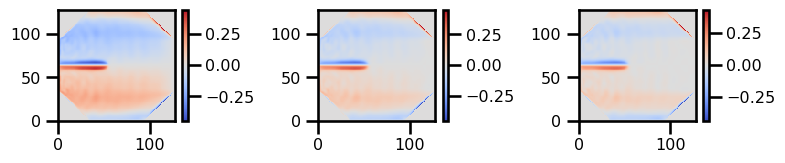

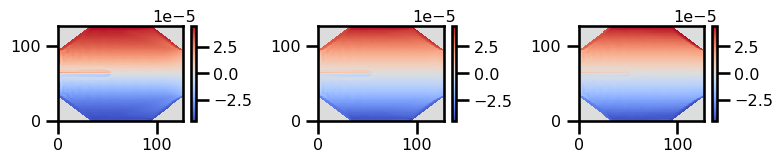

In [23]:
plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
plot_field(sol.ys.q[-1])

### Re-Run Simulation

In [24]:
%%time
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=State(sol.ys.q[-1], sol.ys.psi[-1]),
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 1min 7s, sys: 1.37 s, total: 1min 9s
Wall time: 1min 7s


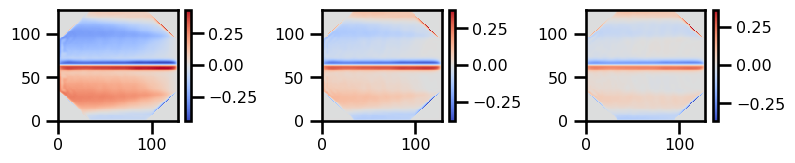

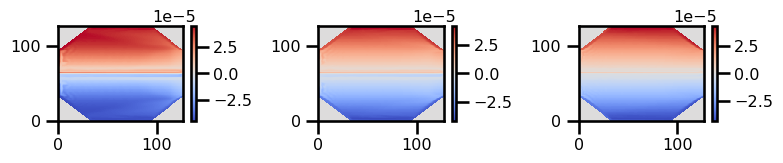

In [25]:
plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
plot_field(sol.ys.q[-1])